# This file performs minimisations using the GNN implicit solvent and compares them to explicit reference calculations.

In [1]:
# Use autoreload
%load_ext autoreload
%autoreload 2

In [2]:
import sys
sys.path.append('..')
sys.path.append('../MachineLearning')
from Simulator import Simulator, Multi_simulator
from ForceField.Forcefield import OpenFF_forcefield_vacuum, OpenFF_forcefield_vacuum_plus_custom
from openmm import LangevinMiddleIntegrator
from openmm.unit import *
from MachineLearning.GNN_Models import *
from MachineLearning.GNN_Trainer import Trainer
from rdkit import Chem
from rdkit.Chem import AllChem
from rdkit.Chem import rdDistGeom
from copy import deepcopy
import matplotlib.pyplot as plt
import mdtraj
import pandas as pd
import tempfile
import os
from Analysis.analysis import *


In [250]:
def get_dihedrals_by_name(traj,i,j,k,l,ins=2):


    if isinstance(traj,list):
        dis = []
        for t in traj:
            dis.append(get_dihedrals_by_name(t,i,j,k,l,ins))
        return dis

    oc = 0
    for a,atom in enumerate(traj.top.atoms):
        if str(atom)[-len(i):] == i:
            i_id = a
            oc += 1
        if str(atom)[-len(j):] == j:
            j_id = a
            oc += 1
        if str(atom)[-len(k):] == k:
            k_id = a
            oc += 1
        if str(atom)[-len(l):] == l:
            l_id = a
            oc += 1
    assert oc == 4
    
    return mdtraj.compute_dihedrals(traj,[[i_id,j_id,k_id,l_id]])

def get_prob(d1,d2,num=50):
    z, xedge, yedge = np.histogram2d(d1,d2,density=True,bins=np.linspace(-np.pi,np.pi,num=num))
    x = 0.5 * (xedge[:-1] + xedge[1:])
    y = 0.5 * (yedge[:-1] + yedge[1:])
    z = z.T

    return x,y,z

def get_xyz(d1,d2,num_bins=50):
    z, xedge, yedge = np.histogram2d(d1,d2,density=False,bins=np.linspace(-np.pi,np.pi,num=num_bins))
    x = 0.5 * (xedge[:-1] + xedge[1:])
    y = 0.5 * (yedge[:-1] + yedge[1:])
    z = z.T

    kjz = in_kjmol(z)

    return x,y,kjz

def get_xz(d1):
    z, xedge = np.histogram(d1,bins=100)
    x = 0.5 * (xedge[:-1] + xedge[1:])
    z = z.T

    return x,in_kjmol(z)

def initialize_plt(figsize = (15,10),fontsize = 22):
    # initialice Matplotlib
    _=plt.figure()
    plt.rcParams["figure.figsize"] = figsize
    plt.rcParams.update({'font.size': fontsize})
    plt.rcParams.update({'font.family':'Sans'})

def plot_free_energy(ax,dis,nbins,range=[0.1,0.7],color='blue',label='',ret_xz=False,linewidth=5,linestyle='solid'):

    if not isinstance(dis,list):
        dis = [dis]

    zs = []
    for d in dis:
        z, xedge = np.histogram(d,bins=nbins,range=range)
        x = 0.5 * (xedge[:-1] + xedge[1:])
        z = z.T
        zs.append(z)

    valuey = np.array([in_kjmol(z) for z in zs])
    mean_y = np.nanmean(valuey,axis=0) - np.min(np.nanmean(valuey,axis=0)) # static shift
    std_y = np.nanstd(valuey,axis=0)
    if ret_xz:
        return x, mean_y, std_y
    ax.plot(x,mean_y,linewidth=linewidth,color=color,label=label,linestyle=linestyle)
    ax.fill_between(x=x,y1=mean_y - std_y,y2=mean_y + std_y,color=color, alpha=0.3)

def normalize(arr):
    arr[arr==0] = np.min(arr[arr>0])
    return arr / np.sum(arr)

def in_kjmol(z):
    kT = 2.479
    z[z==0] = np.min(z[z>0])
    return (-np.log(normalize(z)) - np.min(-np.log(normalize(z)))) * kT

def get_distance_by_name(traj,n1,n2,ins=2):
    if isinstance(traj,list):
        dis = []
        for t in traj:
            dis.append(get_distance_by_name(t,n1,n2,ins))
        return dis

    oc = 0
    for a,atom in enumerate(traj.top.atoms):
        if str(atom)[-len(n1):] == n1:
            n1_id = a
            oc += 1
        if str(atom)[-len(n2):] == n2:
            n2_id = a
            oc += 1
    assert oc == 2
    
    return calculate_distance(traj.xyz,(n1_id, n2_id))

def calculate_distance(xyz,fromto):
    return np.reshape(np.sqrt(np.sum((xyz[:,fromto[0]]-xyz[:,fromto[1]])**2,axis=1)),(xyz.shape[0],1))

def calculate_ETKDGv3(mol, conformer_num=1000,pruneRmsThresh=0.1):
    mol = Chem.AddHs(mol)

    etkdg = rdDistGeom.ETKDGv3()
    etkdg.randomSeed = 0xa700f
    etkdg.verbose = False
    etkdg.numThreads = 8
    etkdg.useExpTorsionAnglePrefs = True
    etkdg.ETversion = 2
    etkdg.pruneRmsThresh = pruneRmsThresh
    AllChem.EmbedMultipleConfs(mol, numConfs=conformer_num, params=etkdg)
    
    with tempfile.NamedTemporaryFile() as tmp:
        Chem.MolToPDBFile(mol,tmp.name)
        traj = mdtraj.load_pdb(tmp.name)

    return traj

def calculate_DGv3(mol, conformer_num=1000,return_mol=False,pruneRmsThresh=0.1):
    mol = Chem.AddHs(mol)

    etkdg = rdDistGeom.ETKDGv3()
    etkdg.randomSeed = 0xa700f
    etkdg.verbose = False
    etkdg.numThreads = 8
    etkdg.useExpTorsionAnglePrefs = False
    etkdg.ETversion = 2
    #use cutoff
    etkdg.pruneRmsThresh = pruneRmsThresh
    AllChem.EmbedMultipleConfs(mol, numConfs=conformer_num, params=etkdg)
    
    with tempfile.NamedTemporaryFile() as tmp:
        Chem.MolToPDBFile(mol,tmp.name)
        traj = mdtraj.load_pdb(tmp.name)

    if return_mol:
        return traj, mol
    return traj

def calculate_MMFF(mol, conformer_num=1000,pruneRmsThresh=0.1):
    mol = Chem.AddHs(mol)

    etkdg = rdDistGeom.ETKDGv3()
    etkdg.randomSeed = 0xa700f
    etkdg.verbose = False
    etkdg.numThreads = 8
    etkdg.useExpTorsionAnglePrefs = False
    etkdg.ETversion = 2
    etkdg.pruneRmsThresh = pruneRmsThresh

    AllChem.EmbedMultipleConfs(mol, numConfs=conformer_num, params=etkdg)
    AllChem.MMFFOptimizeMoleculeConfs(mol)
    
    with tempfile.NamedTemporaryFile() as tmp:
        Chem.MolToPDBFile(mol,tmp.name)
        traj = mdtraj.load_pdb(tmp.name)

    return traj

def load_trajectories(ce_id):
    file_location = '/fileserver/pine/pine8/kpaul/small_molecule_pub/Simulation/simulation/conformational_ensemble_smiles/'
    if os.path.isfile(file_location + 'conformational_ensemble_smiles_id_%i_openff200_tip3p_0_161311_output_stripped.h5' % ce_id):
        stripped_tip3p_traj = mdtraj.load(file_location + 'conformational_ensemble_smiles_id_%i_openff200_tip3p_0_161311_output_stripped.h5' % ce_id)
    else:
        tip3p_traj = mdtraj.load(file_location + 'conformational_ensemble_smiles_id_%i_openff200_tip3p_0_161311_output.h5' % ce_id)
        stripped_tip3p_traj = tip3p_traj.atom_slice(tip3p_traj.top.select('resid %i' % (tip3p_traj.top.n_residues - 1)))
        stripped_tip3p_traj.save(file_location + 'conformational_ensemble_smiles_id_%i_openff200_tip3p_0_161311_output_stripped.h5' % ce_id)

    file_location = '/fileserver/pine/pine8/kpaul/small_molecule_pub/Simulation/simulation/conformational_ensemble_smiles_pub/'
    gnn_traj = load_parallel_traj(nrep=128,file=file_location + 'conformational_ensemble_smiles_id_%i_openff200_vacuum_plus_GNN3_multi_128_model_64_random_2_0_2_output.h5' % ce_id)
    file_location = '/fileserver/pine/pine8/kpaul/small_molecule_pub/Simulation/simulation/conformational_ensemble_smiles/'
    return stripped_tip3p_traj, gnn_traj

def create_vac_sim(smiles,cache=None,num_confs=64):
    pdb_id = smiles + '_in_v'
    workdir = '/tmp/'
    vac_sim = Multi_simulator(work_dir=workdir,pdb_id=pdb_id,run_name=pdb_id,num_rep=num_confs,cache=cache)
    vac_sim.forcefield = OpenFF_forcefield_vacuum(pdb_id,cache=cache)
    vac_sim.integrator = LangevinMiddleIntegrator(300*kelvin, 1/picosecond, 0.002*picoseconds)
    vac_sim._ref_system.integrator = LangevinMiddleIntegrator(300*kelvin, 1/picosecond, 0.002*picoseconds)
    vac_sim._ref_system.forcefield = OpenFF_forcefield_vacuum(pdb_id,cache=cache)
    vac_sim._ref_system.platform = "GPU"
    vac_sim.setup_replicates()
    return vac_sim

def load_explicit_solvent_reference(id,solvent_smiles):

    path = '/media/kpaul/173c6995-ac7e-467a-9881-4c8910d98285/kpaul/small_molecule_multisolvent/Simulation/simulation/conformational_ensemble_smiles/'
    
    if os.path.isfile(path + 'conformational_ensemble_smiles_id_%i_openff200_%s_0_161311_output_stripped.h5' % (id,solvent_smiles)):
        stripped_traj = mdtraj.load(path + 'conformational_ensemble_smiles_id_%i_openff200_%s_0_161311_output_stripped.h5' % (id,solvent_smiles))
    else:
        traj = mdtraj.load(path + 'conformational_ensemble_smiles_id_%i_openff200_%s_0_161311_output.h5' % (id,solvent_smiles))
        stripped_traj = traj.atom_slice(traj.top.select('resid %i' % (traj.top.n_residues - 1)))
        stripped_traj.save(path + 'conformational_ensemble_smiles_id_%i_openff200_%s_0_161311_output_stripped.h5' % (id,solvent_smiles))
    
    return stripped_traj

def plot_single_contour_f(ax,x,y,kjz,colors='Blues_r',vmax=20,levels=10):

    # set axis equal
    ax.set_aspect('equal', 'box')
    # set axis range
    ax.set_xlim(-np.pi,np.pi)
    ax.set_ylim(-np.pi,np.pi)
    # set axis label
    ax.set_xlabel(r'$\phi$')
    ax.set_ylabel(r'$\psi$')
    # set axis ticks
    ax.set_xticks([-np.pi,-np.pi/2,0,np.pi/2,np.pi])
    ax.set_xticklabels([r'$-\pi$',r'$-\frac{\pi}{2}$',r'$0$',r'$\frac{\pi}{2}$',r'$\pi$'])
    ax.set_yticks([-np.pi,-np.pi/2,0,np.pi/2,np.pi])
    ax.set_yticklabels([r'$-\pi$',r'$-\frac{\pi}{2}$',r'$0$',r'$\frac{\pi}{2}$',r'$\pi$'])
    contour = ax.contourf(x,y,kjz,levels=levels,cmap=colors,vmax=vmax)
    return contour

def plot_contour_f(axd,x,y,kjz,colors='Blues_r',vmax=20,levels=10):
    for ax in axd.values():
        countour = plot_single_contour_f(ax,x,y,kjz,colors=colors,vmax=vmax,levels=levels)
    return countour


torsion_dict ={0:[('C7','C6','C5','N1'),('C5','N1','C4','C3')],
               1:[('C7','C6','C5','N1'),('C5','N1','C4','C3')],
               2:[('C1','C10','N1','H8'),('C13','C12','C11','O2')],
               3:[('C5','C6','N1','C7'),('C9','C8','C7','O2')],
               4:[('C5','C6','N1','C7'),('C9','C8','C7','O2')],}

### Generate conformers

In [179]:
id = 3

In [180]:
stripped_tip3p_traj, gnn_traj = load_trajectories(id)
stripped_CHCl3_traj = load_explicit_solvent_reference(id,'ClC(Cl)Cl')
stripped_CO_traj = load_explicit_solvent_reference(id,'CO')
stripped_DMSO_traj = load_explicit_solvent_reference(id,'CS(=O)C')

/localhome/kpaul/.conda/envs/newest_pyg_ot14/lib/python3.10/site-packages/mdtraj/core/trajectory.py:438: UserWarning: top= kwargs ignored since this file parser does not support it
  warnings.warn('top= kwargs ignored since this file parser does not support it')


In [181]:
file = 'simulation_smiles/conformational_ensemble_smiles.txt'
smiles = pd.read_table(file,names=['smi']).values.T[0][id]
smiles

'Oc1ccccc1NC(=O)C(CO)(C)C'

In [294]:
mol = Chem.MolFromSmiles(smiles)
dg_traj, dgmol = calculate_DGv3(deepcopy(mol),conformer_num=64*20,return_mol=True,pruneRmsThresh=0.1)
etkdg_traj = calculate_ETKDGv3(deepcopy(mol),conformer_num=64*20,pruneRmsThresh=0.1)
mmff_traj = calculate_MMFF(deepcopy(mol),conformer_num=64*20,pruneRmsThresh=0.1)

In [297]:
d1_dg = get_dihedrals_by_name(dg_traj,*torsion_dict[id][0])
d2_dg = get_dihedrals_by_name(dg_traj,*torsion_dict[id][1])
d1_etkdg = get_dihedrals_by_name(etkdg_traj,*torsion_dict[id][0])
d2_etkdg = get_dihedrals_by_name(etkdg_traj,*torsion_dict[id][1])
d1_mmff = get_dihedrals_by_name(mmff_traj,*torsion_dict[id][0])
d2_mmff = get_dihedrals_by_name(mmff_traj,*torsion_dict[id][1])

d1_tip3p = get_dihedrals_by_name(stripped_tip3p_traj,*torsion_dict[id][0])
d2_tip3p = get_dihedrals_by_name(stripped_tip3p_traj,*torsion_dict[id][1])
x,y,kjz = get_xyz(d1_tip3p.T[0],d2_tip3p.T[0],50)

d1_CHCl3 = get_dihedrals_by_name(stripped_CHCl3_traj,*torsion_dict[id][0])
d2_CHCl3 = get_dihedrals_by_name(stripped_CHCl3_traj,*torsion_dict[id][1])
x_CHCl3,y_CHCl3,kjz_CHCl3 = get_xyz(d1_CHCl3.T[0],d2_CHCl3.T[0],50)

d1_CO = get_dihedrals_by_name(stripped_CO_traj,*torsion_dict[id][0])
d2_CO = get_dihedrals_by_name(stripped_CO_traj,*torsion_dict[id][1])
x_CO,y_CO,kjz_CO = get_xyz(d1_CO.T[0],d2_CO.T[0],50)

d1_DMSO = get_dihedrals_by_name(stripped_DMSO_traj,*torsion_dict[id][0])
d2_DMSO = get_dihedrals_by_name(stripped_DMSO_traj,*torsion_dict[id][1])
x_DMSO,y_DMSO,kjz_DMSO = get_xyz(d1_DMSO.T[0],d2_DMSO.T[0],50)

d1_gnn = get_dihedrals_by_name(gnn_traj,*torsion_dict[id][0])
d2_gnn = get_dihedrals_by_name(gnn_traj,*torsion_dict[id][1])

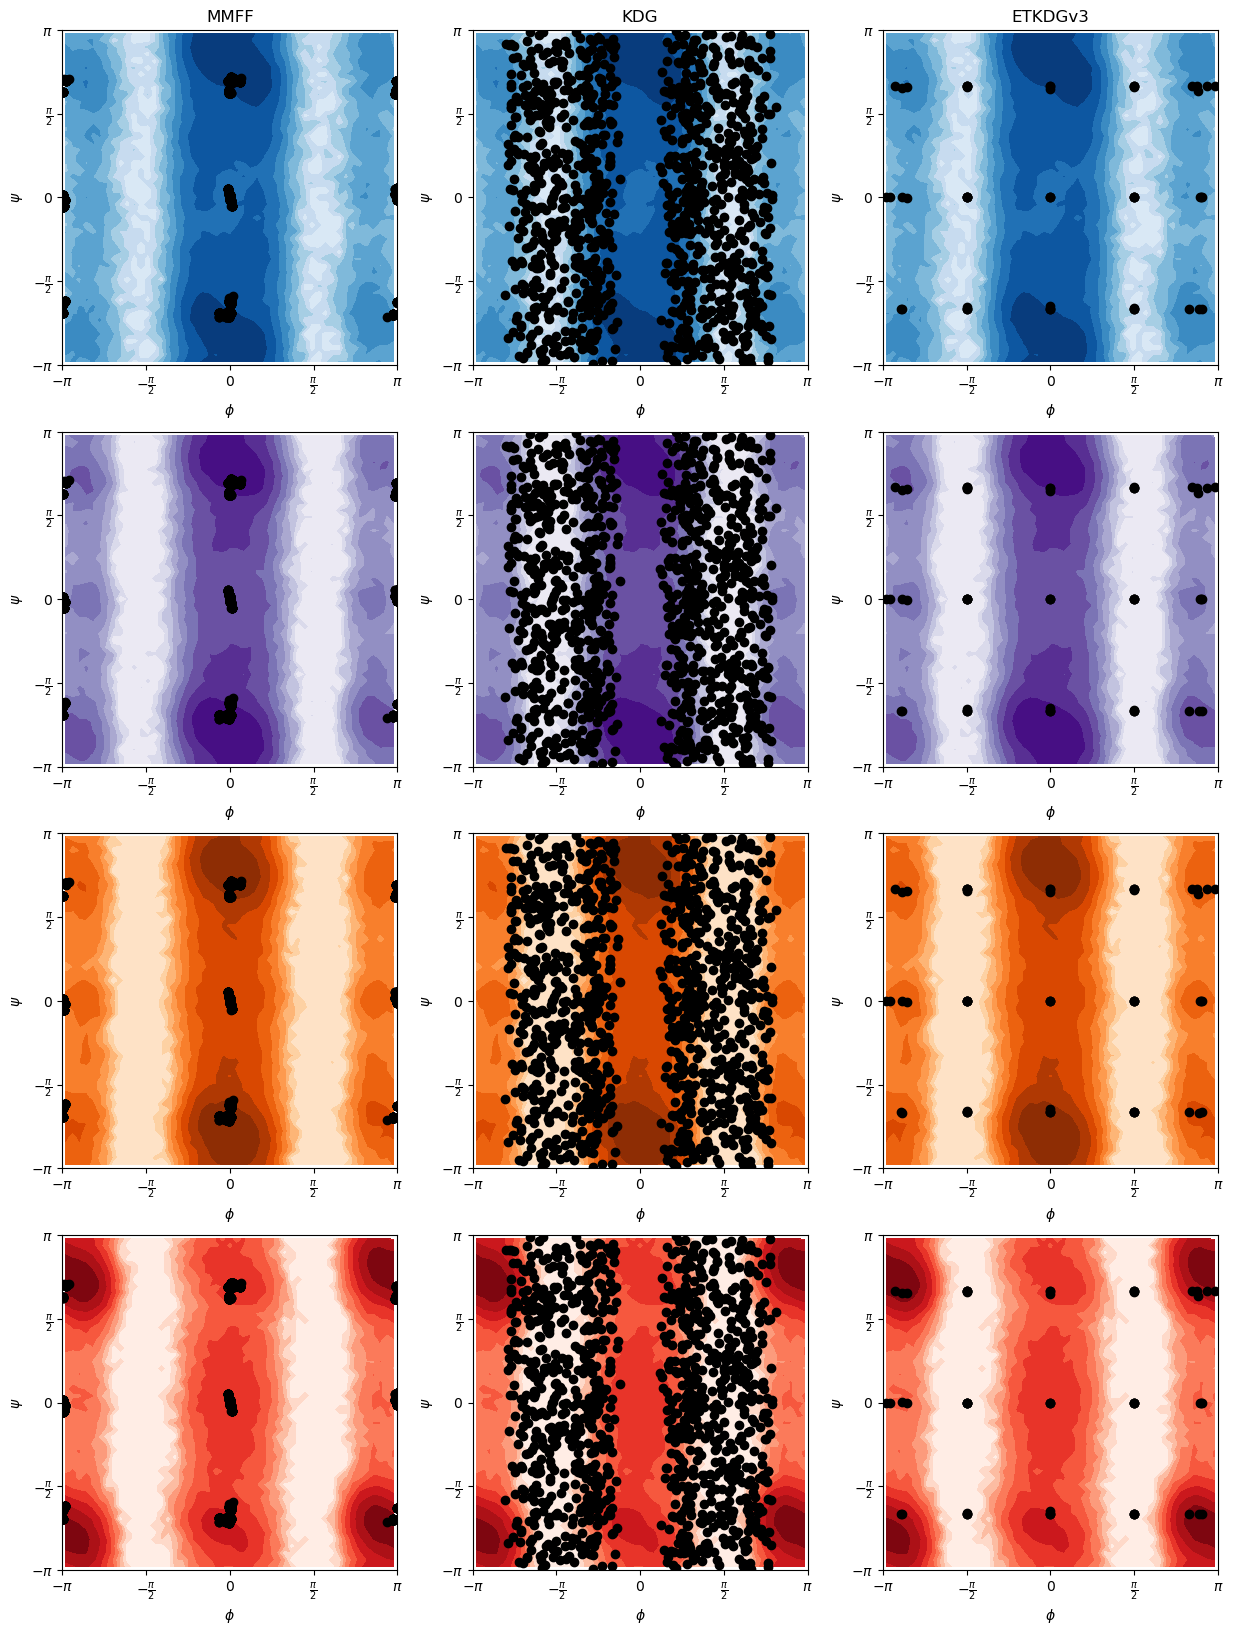

In [298]:
fig, axd = plt.subplot_mosaic([['mmff','dg','etkdg'],
                               ['mmff_CO','dg_CO','etkdg_CO'],
                               ['mmff_DMSO','dg_DMSO','etkdg_DMSO'],
                               ['mmff_CHCl3','dg_CHCl3','etkdg_CHCl3']]
                               ,figsize=(15,20))
axd['dg'].set_title('KDG')
axd['etkdg'].set_title('ETKDGv3')
axd['mmff'].set_title('MMFF')

for ax in axd.values():
    # set axis equal
    ax.set_aspect('equal')
    # set axis range
    ax.set_xlim(-np.pi,np.pi)
    ax.set_ylim(-np.pi,np.pi)
    # set axis label
    ax.set_xlabel(r'$\phi$')
    ax.set_ylabel(r'$\psi$')
    # set axis ticks
    ax.set_xticks([-np.pi,-np.pi/2,0,np.pi/2,np.pi])
    ax.set_xticklabels([r'$-\pi$',r'$-\frac{\pi}{2}$',r'$0$',r'$\frac{\pi}{2}$',r'$\pi$'])
    ax.set_yticks([-np.pi,-np.pi/2,0,np.pi/2,np.pi])
    ax.set_yticklabels([r'$-\pi$',r'$-\frac{\pi}{2}$',r'$0$',r'$\frac{\pi}{2}$',r'$\pi$'])

axd['dg'].contourf(x,y,kjz,levels=10,cmap='Blues_r',vmax=20)
axd['etkdg'].contourf(x,y,kjz,levels=10,cmap='Blues_r',vmax=20)
axd['mmff'].contourf(x,y,kjz,levels=10,cmap='Blues_r',vmax=20)

axd['dg_CHCl3'].contourf(x_CHCl3,y_CHCl3,kjz_CHCl3,levels=10,cmap='Reds_r',vmax=20)
axd['etkdg_CHCl3'].contourf(x_CHCl3,y_CHCl3,kjz_CHCl3,levels=10,cmap='Reds_r',vmax=20)
axd['mmff_CHCl3'].contourf(x_CHCl3,y_CHCl3,kjz_CHCl3,levels=10,cmap='Reds_r',vmax=20)

axd['dg_CO'].contourf(x_CO,y_CO,kjz_CO,levels=10,cmap='Purples_r',vmax=20)
axd['etkdg_CO'].contourf(x_CO,y_CO,kjz_CO,levels=10,cmap='Purples_r',vmax=20)
axd['mmff_CO'].contourf(x_CO,y_CO,kjz_CO,levels=10,cmap='Purples_r',vmax=20)

axd['dg_DMSO'].contourf(x_DMSO,y_DMSO,kjz_DMSO,levels=10,cmap='Oranges_r',vmax=20)
axd['etkdg_DMSO'].contourf(x_DMSO,y_DMSO,kjz_DMSO,levels=10,cmap='Oranges_r',vmax=20)
axd['mmff_DMSO'].contourf(x_DMSO,y_DMSO,kjz_DMSO,levels=10,cmap='Oranges_r',vmax=20)

axd['dg'].scatter(d1_dg,d2_dg,color='black')
axd['etkdg'].scatter(d1_etkdg,d2_etkdg,color='black')
axd['mmff'].scatter(d1_mmff,d2_mmff,color='black')

axd['dg_CHCl3'].scatter(d1_dg,d2_dg,color='black')
axd['etkdg_CHCl3'].scatter(d1_etkdg,d2_etkdg,color='black')
axd['mmff_CHCl3'].scatter(d1_mmff,d2_mmff,color='black')

axd['dg_CO'].scatter(d1_dg,d2_dg,color='black')
axd['etkdg_CO'].scatter(d1_etkdg,d2_etkdg,color='black')
axd['mmff_CO'].scatter(d1_mmff,d2_mmff,color='black')

axd['dg_DMSO'].scatter(d1_dg,d2_dg,color='black')
axd['etkdg_DMSO'].scatter(d1_etkdg,d2_etkdg,color='black')
axd['mmff_DMSO'].scatter(d1_mmff,d2_mmff,color='black')

fig.savefig('../Analysis/Plots/ID_%i_etkdg.pdf' % id)

In [299]:
def plot_colorbar_legend(ax,levels,vmax):
    levels = levels
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)
    ax.axis('off')
    bounds = [vmax/levels*i for i in range(levels+2)]
    cmap = 'Greys_r'
    norm = mtl.colors.Normalize(vmin=0, vmax=vmax)
    axins = ax.inset_axes([0.25, 0, 0.5, 0.5])
    cb1 = mtl.colorbar.ColorbarBase(axins, cmap=cmap,norm=norm,boundaries=bounds,ticks=bounds[::2], orientation='horizontal')
    cb1.set_label(r'free energy $\left[\frac{\mathrm{kJ}}{\mathrm{mol}}\right]$')

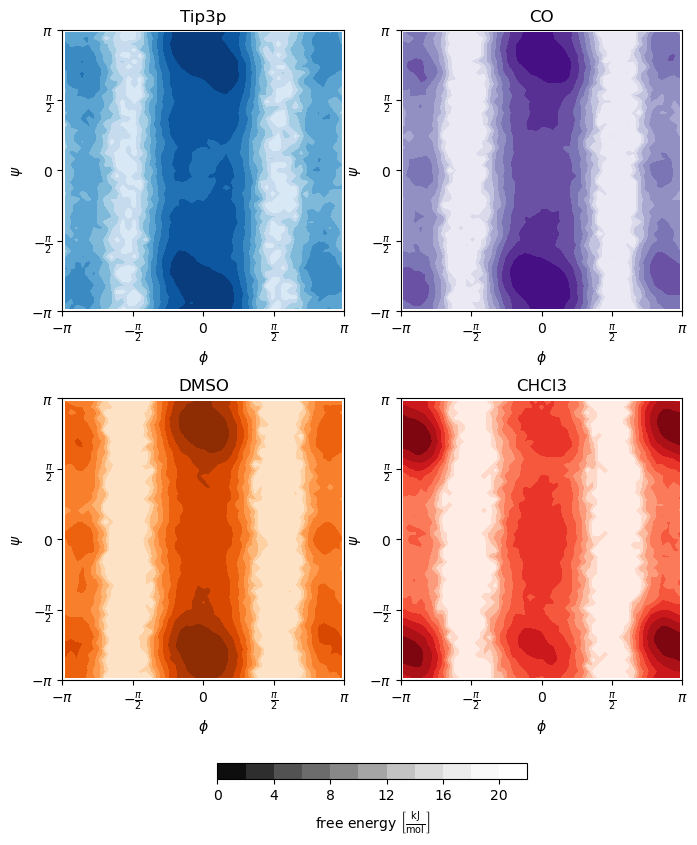

In [300]:
fig, axd = plt.subplot_mosaic([['tip3p','CO'],
                                ['DMSO','CHCl3'],
                                ['legend','legend']],figsize=(8,10),height_ratios=[1,1,0.1])

axd['tip3p'].set_title('Tip3p')
axd['CO'].set_title('CO')
axd['DMSO'].set_title('DMSO')
axd['CHCl3'].set_title('CHCl3')

plot_single_contour_f(axd['tip3p'],x,y,kjz,colors='Blues_r',vmax=20,levels=10)
plot_single_contour_f(axd['CO'],x_CO,y_CO,kjz_CO,colors='Purples_r',vmax=20,levels=10)
plot_single_contour_f(axd['DMSO'],x_DMSO,y_DMSO,kjz_DMSO,colors='Oranges_r',vmax=20,levels=10)
plot_single_contour_f(axd['CHCl3'],x_CHCl3,y_CHCl3,kjz_CHCl3,colors='Reds_r',vmax=20,levels=10)
plot_colorbar_legend(axd['legend'],levels=10,vmax=20)

fig.savefig('../Analysis/Plots/ID_%i_solvents.pdf' % id)

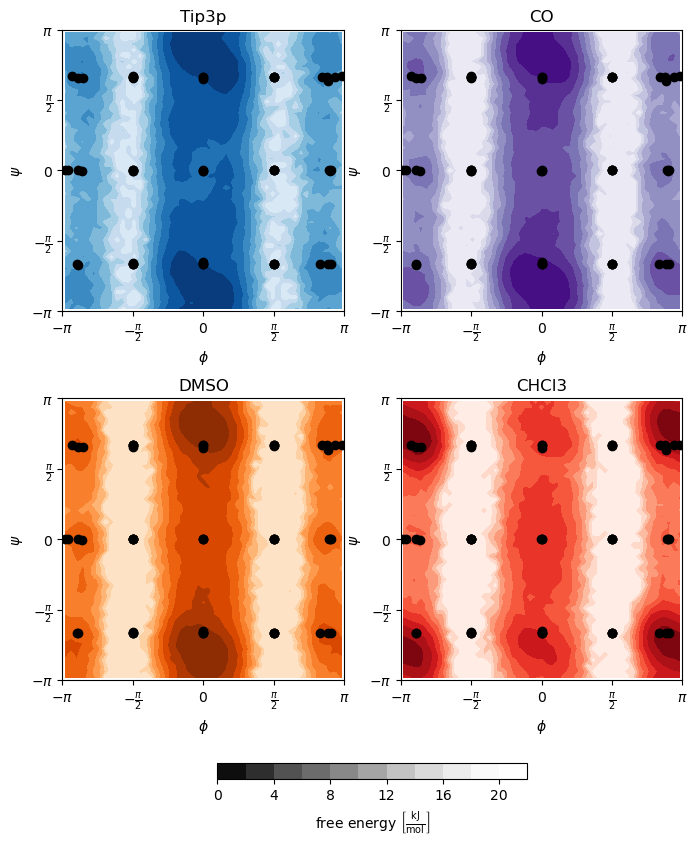

In [301]:
fig, axd = plt.subplot_mosaic([['tip3p','CO'],
                                ['DMSO','CHCl3'],
                                ['legend','legend']],figsize=(8,10),height_ratios=[1,1,0.1])

axd['tip3p'].set_title('Tip3p')
axd['CO'].set_title('CO')
axd['DMSO'].set_title('DMSO')
axd['CHCl3'].set_title('CHCl3')

plot_single_contour_f(axd['tip3p'],x,y,kjz,colors='Blues_r',vmax=20,levels=10)
plot_single_contour_f(axd['CO'],x_CO,y_CO,kjz_CO,colors='Purples_r',vmax=20,levels=10)
plot_single_contour_f(axd['DMSO'],x_DMSO,y_DMSO,kjz_DMSO,colors='Oranges_r',vmax=20,levels=10)
plot_single_contour_f(axd['CHCl3'],x_CHCl3,y_CHCl3,kjz_CHCl3,colors='Reds_r',vmax=20,levels=10)
plot_colorbar_legend(axd['legend'],levels=10,vmax=20)

for key in ['tip3p','CO','DMSO','CHCl3']:
    axd[key].scatter(d1_etkdg,d2_etkdg,color='black')

fig.savefig('../Analysis/Plots/ID_%i_solvents_etkdg.pdf' % id)

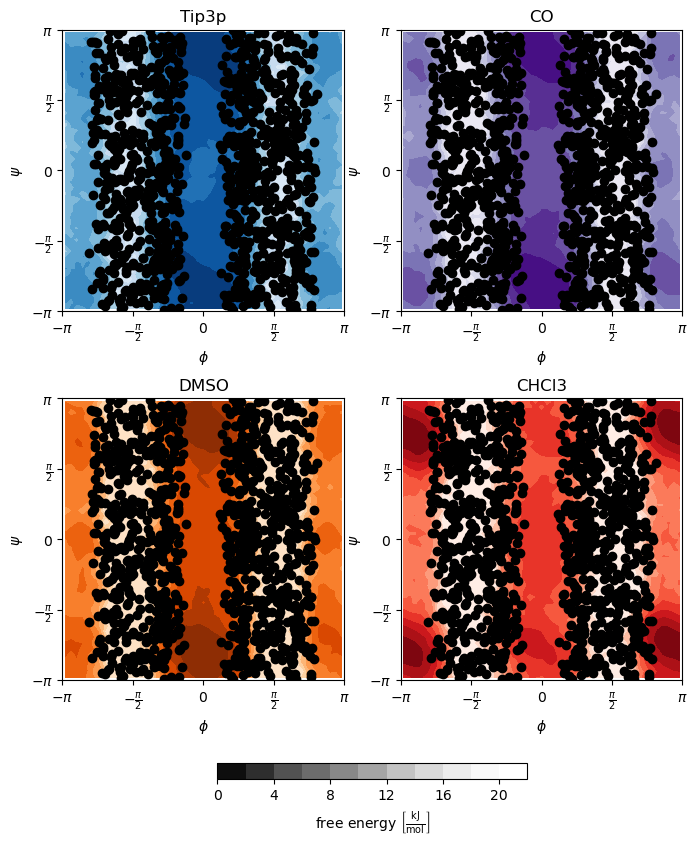

In [302]:
fig, axd = plt.subplot_mosaic([['tip3p','CO'],
                                ['DMSO','CHCl3'],
                                ['legend','legend']],figsize=(8,10),height_ratios=[1,1,0.1])

axd['tip3p'].set_title('Tip3p')
axd['CO'].set_title('CO')
axd['DMSO'].set_title('DMSO')
axd['CHCl3'].set_title('CHCl3')

plot_single_contour_f(axd['tip3p'],x,y,kjz,colors='Blues_r',vmax=20,levels=10)
plot_single_contour_f(axd['CO'],x_CO,y_CO,kjz_CO,colors='Purples_r',vmax=20,levels=10)
plot_single_contour_f(axd['DMSO'],x_DMSO,y_DMSO,kjz_DMSO,colors='Oranges_r',vmax=20,levels=10)
plot_single_contour_f(axd['CHCl3'],x_CHCl3,y_CHCl3,kjz_CHCl3,colors='Reds_r',vmax=20,levels=10)
plot_colorbar_legend(axd['legend'],levels=10,vmax=20)

for key in ['tip3p','CO','DMSO','CHCl3']:
    axd[key].scatter(d1_dg,d2_dg,color='black')

fig.savefig('../Analysis/Plots/ID_%i_solvents_kdg.pdf' % id)

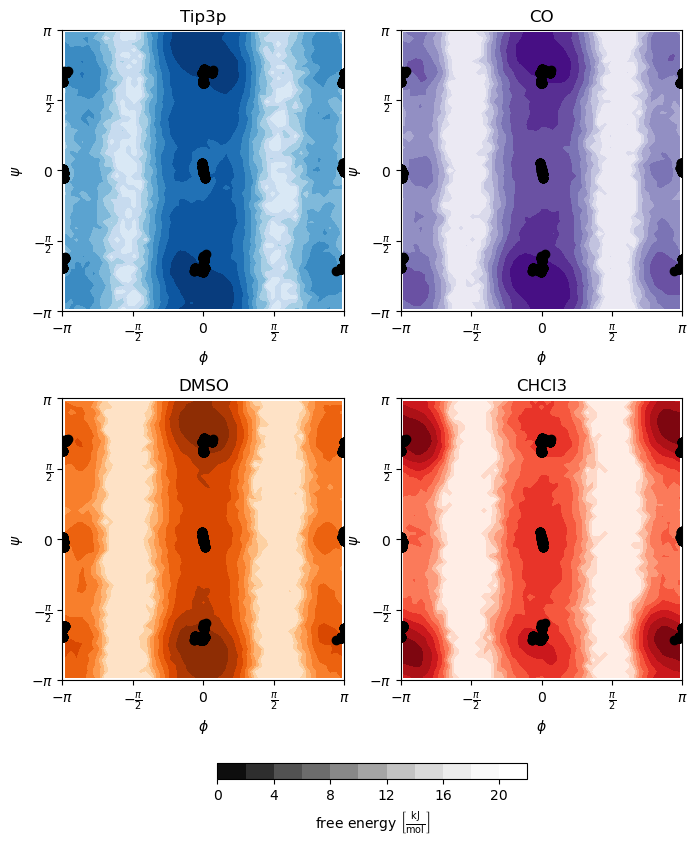

In [303]:
fig, axd = plt.subplot_mosaic([['tip3p','CO'],
                                ['DMSO','CHCl3'],
                                ['legend','legend']],figsize=(8,10),height_ratios=[1,1,0.1])

axd['tip3p'].set_title('Tip3p')
axd['CO'].set_title('CO')
axd['DMSO'].set_title('DMSO')
axd['CHCl3'].set_title('CHCl3')

plot_single_contour_f(axd['tip3p'],x,y,kjz,colors='Blues_r',vmax=20,levels=10)
plot_single_contour_f(axd['CO'],x_CO,y_CO,kjz_CO,colors='Purples_r',vmax=20,levels=10)
plot_single_contour_f(axd['DMSO'],x_DMSO,y_DMSO,kjz_DMSO,colors='Oranges_r',vmax=20,levels=10)
plot_single_contour_f(axd['CHCl3'],x_CHCl3,y_CHCl3,kjz_CHCl3,colors='Reds_r',vmax=20,levels=10)
plot_colorbar_legend(axd['legend'],levels=10,vmax=20)

for key in ['tip3p','CO','DMSO','CHCl3']:
    axd[key].scatter(d1_mmff,d2_mmff,color='black')

fig.savefig('../Analysis/Plots/ID_%i_solvents_mmff.pdf' % id)

#### Run Vacuum Simulation

In [304]:
def set_positions_for_simulation(sim,mol,num_confs=64,iteration=0):
    positions = []
    for i in range((iteration*num_confs),((iteration+1)*num_confs)):
        pos = mol.GetConformer(i).GetPositions()
        positions.append(pos/10)
    positions = np.array(positions)
    sim.set_positions(positions.reshape(-1,positions.shape[-1]))
    return sim

def run_minimisation(sim,tolerance=1e-4,max_iterations=0):
    sim._simulation.minimizeEnergy(tolerance=tolerance, maxIterations=max_iterations)
    return sim

def get_minimised_positions(sim):
    return sim._simulation.context.getState(getPositions=True).getPositions(asNumpy=True).value_in_unit(nanometer)

def get_traj_from_positions(mol,positions,num_iters=1,num_confs=64):
    with tempfile.NamedTemporaryFile() as tmp:
        Chem.MolToPDBFile(mol,tmp.name)
        traj = mdtraj.load_pdb(tmp.name)

    traj_optimised = traj[:]
    n_atoms = mol.GetNumAtoms()
    for ni in range(num_iters):
        for i in range(num_confs):
            traj_optimised.xyz[ni*num_confs+i] = positions[ni][i*n_atoms:(i+1)*n_atoms]
    
    return traj_optimised


In [305]:
num_confs = 64
num_iters = 8

In [306]:
positions = []
vac_sim = create_vac_sim(smiles,cache='/tmp/tmp.cache',num_confs=num_confs)
for i in range(num_iters):
    vac_sim = set_positions_for_simulation(vac_sim,dgmol,num_confs=num_confs,iteration=i)
    vac_sim = run_minimisation(vac_sim)
    positions.append(get_minimised_positions(vac_sim))
opff_traj = get_traj_from_positions(dgmol,positions,num_iters=num_iters,num_confs=num_confs)[:num_iters*num_confs]

Platform:  GPU  ready
Platform:  GPU  ready
Platform:  GPU  ready
Platform:  GPU  ready
All parallel systems have the same forces as the reference System


In [307]:
d1_opff = get_dihedrals_by_name(opff_traj,*torsion_dict[id][0])
d2_opff = get_dihedrals_by_name(opff_traj,*torsion_dict[id][1])

### Add GNN minimisation

In [308]:
from openmmtorch import TorchForce

def create_gnn_sim(smiles,cache=None,num_confs=64,setup_dict=None):
    assert setup_dict is not None

    pdb_id = smiles + '_in_v'
    workdir = '/tmp/'
    gnn_sim = Multi_simulator(work_dir=workdir,pdb_id=pdb_id,run_name=pdb_id,num_rep=num_confs,cache=cache)

    trainer = Trainer(verbose=True,name='RunMinimisation',force_mode=True,enable_tmp_dir=False,random_state=10,device='cuda')
    trained_model = setup_dict['trained_model']
    radius = 0.6
    fraction = 0.1
    random_seed = '10'
    model = setup_dict['model']
    run_model = setup_dict['run_model']
    runfile, reffile = gnn_sim.generate_model_pt_file(trainer,workdir,pdb_id,trained_model,radius,fraction,model,run_model,random_seed,device='cuda')

    torch_force = TorchForce(runfile)
    gnn_sim.integrator = LangevinMiddleIntegrator(300*kelvin, 1/picosecond, 0.002*picoseconds)
    gnn_sim.forcefield = OpenFF_forcefield_vacuum_plus_custom(pdb_id,torch_force,'GNN3_vap',cache=cache)
    
    torch_force = TorchForce(reffile)
    gnn_sim._ref_system.integrator = LangevinMiddleIntegrator(300*kelvin, 1/picosecond, 0.002*picoseconds)
    gnn_sim._ref_system.forcefield = OpenFF_forcefield_vacuum_plus_custom(pdb_id,torch_force,'GNN3_vap',cache=cache)
    gnn_sim._ref_system.platform = "GPU"

    gnn_sim.setup_replicates()
    return gnn_sim

def get_energies(sim,traj):

    energies = []
    
    for i in range(traj.n_frames):
        sim._ref_system.set_positions(traj.xyz[i])
        energies.append(sim._ref_system.calculate_energy()._value)
    
    return np.array(energies)

In [309]:
class GNN3_scale_64_run_CHCl3(GNN3_scale_64_run):

    def __init__(self, fraction=0.5, radius=0.4, max_num_neighbors=10000, parameters=None, device=None, jittable=False, num_reps=1, gbneck_radius=10, unique_radii=None, hidden=64, solvent_dielectric=4.81):
        super().__init__(fraction, radius, max_num_neighbors, parameters, device, jittable, num_reps, gbneck_radius, unique_radii, hidden, solvent_dielectric)

class GNN3_scale_64_run_DMSO(GNN3_scale_64_run):

    def __init__(self, fraction=0.5, radius=0.4, max_num_neighbors=10000, parameters=None, device=None, jittable=False, num_reps=1, gbneck_radius=10, unique_radii=None, hidden=64, solvent_dielectric=46.7):
        super().__init__(fraction, radius, max_num_neighbors, parameters, device, jittable, num_reps, gbneck_radius, unique_radii, hidden, solvent_dielectric)

class GNN3_scale_64_run_CO(GNN3_scale_64_run):
    
        def __init__(self, fraction=0.5, radius=0.4, max_num_neighbors=10000, parameters=None, device=None, jittable=False, num_reps=1, gbneck_radius=10, unique_radii=None, hidden=64, solvent_dielectric=32.7):
            super().__init__(fraction, radius, max_num_neighbors, parameters, device, jittable, num_reps, gbneck_radius, unique_radii, hidden, solvent_dielectric)

In [310]:
setup_dict = {'trained_model':'/fileserver/pine/pine8/kpaul/small_molecule_pub/MachineLearning/trained_models/GNN3_pub__batchsize_32_per_0.95_fra_0.1_random_3_radius_0.6_lr_0.0005_epochs_30_modelid_64_name__clip_1.0model.model',                               
                    'model' : GNN3_scale_64,
                    'run_model' : GNN3_scale_64_run}

setup_dict_CHCl3 = {'trained_model':'../MachineLearning/trained_models/GNN3_pub__batchsize_32_per_0.95_fra_0.1_random_1_radius_0.6_lr_0.0005_epochs_5_modelid_64_name__clip_1.0_solvent_dielectric_4.81model.model',                               
                    'model' : GNN3_scale_64,
                    'run_model' : GNN3_scale_64_run_CHCl3}

setup_dict_DMSO = {'trained_model':'../MachineLearning/trained_models/GNN3_pub__batchsize_32_per_0.95_fra_0.1_random_3_radius_0.6_lr_0.0005_epochs_30_modelid_64_name__clip_1.0_solvent_dielectric_46.7_verbose_Falsemodel.model',
                    'model' : GNN3_scale_64,
                    'run_model' : GNN3_scale_64_run_DMSO}

setup_dict_CO = {'trained_model':'../MachineLearning/trained_models/GNN3_pub__batchsize_32_per_0.95_fra_0.1_random_1_radius_0.6_lr_0.0005_epochs_30_modelid_64_name__clip_1.0_solvent_dielectric_32.7_verbose_Falsemodel.model',
                    'model' : GNN3_scale_64,
                    'run_model' : GNN3_scale_64_run_CO}

In [311]:
import tqdm

In [312]:
setup_dicts = {'tip3p':setup_dict,
               'CHCl3':setup_dict_CHCl3,
               'DMSO':setup_dict_DMSO,
               'CO':setup_dict_CO}

In [313]:
solventsmiles = 'tip3p'

In [314]:
positions = []
num_iters = 8
num_confs = 64
gnn_sim = create_gnn_sim(smiles,cache='/tmp/tmp.cache',num_confs=num_confs,setup_dict=setup_dicts[solventsmiles])
for i in tqdm.tqdm(range(num_iters)):
    gnn_sim = set_positions_for_simulation(gnn_sim,dgmol,num_confs=num_confs,iteration=i)
    gnn_sim = run_minimisation(gnn_sim,1e-4,0)
    positions.append(get_minimised_positions(gnn_sim))
gnnff_traj = get_traj_from_positions(dgmol,positions,num_iters=num_iters,num_confs=num_confs)[:num_iters*num_confs]
gnnff_energies = get_energies(gnn_sim,gnnff_traj)

Platform:  GPU  ready
Platform:  GPU  ready
Platform:  GPU  ready
Platform:  GPU  ready
All parallel systems have the same forces as the reference System


100%|██████████| 8/8 [01:30<00:00, 11.28s/it]


In [276]:
d1_gnnff = get_dihedrals_by_name(gnnff_traj,*torsion_dict[id][0])
d2_gnnff = get_dihedrals_by_name(gnnff_traj,*torsion_dict[id][1])

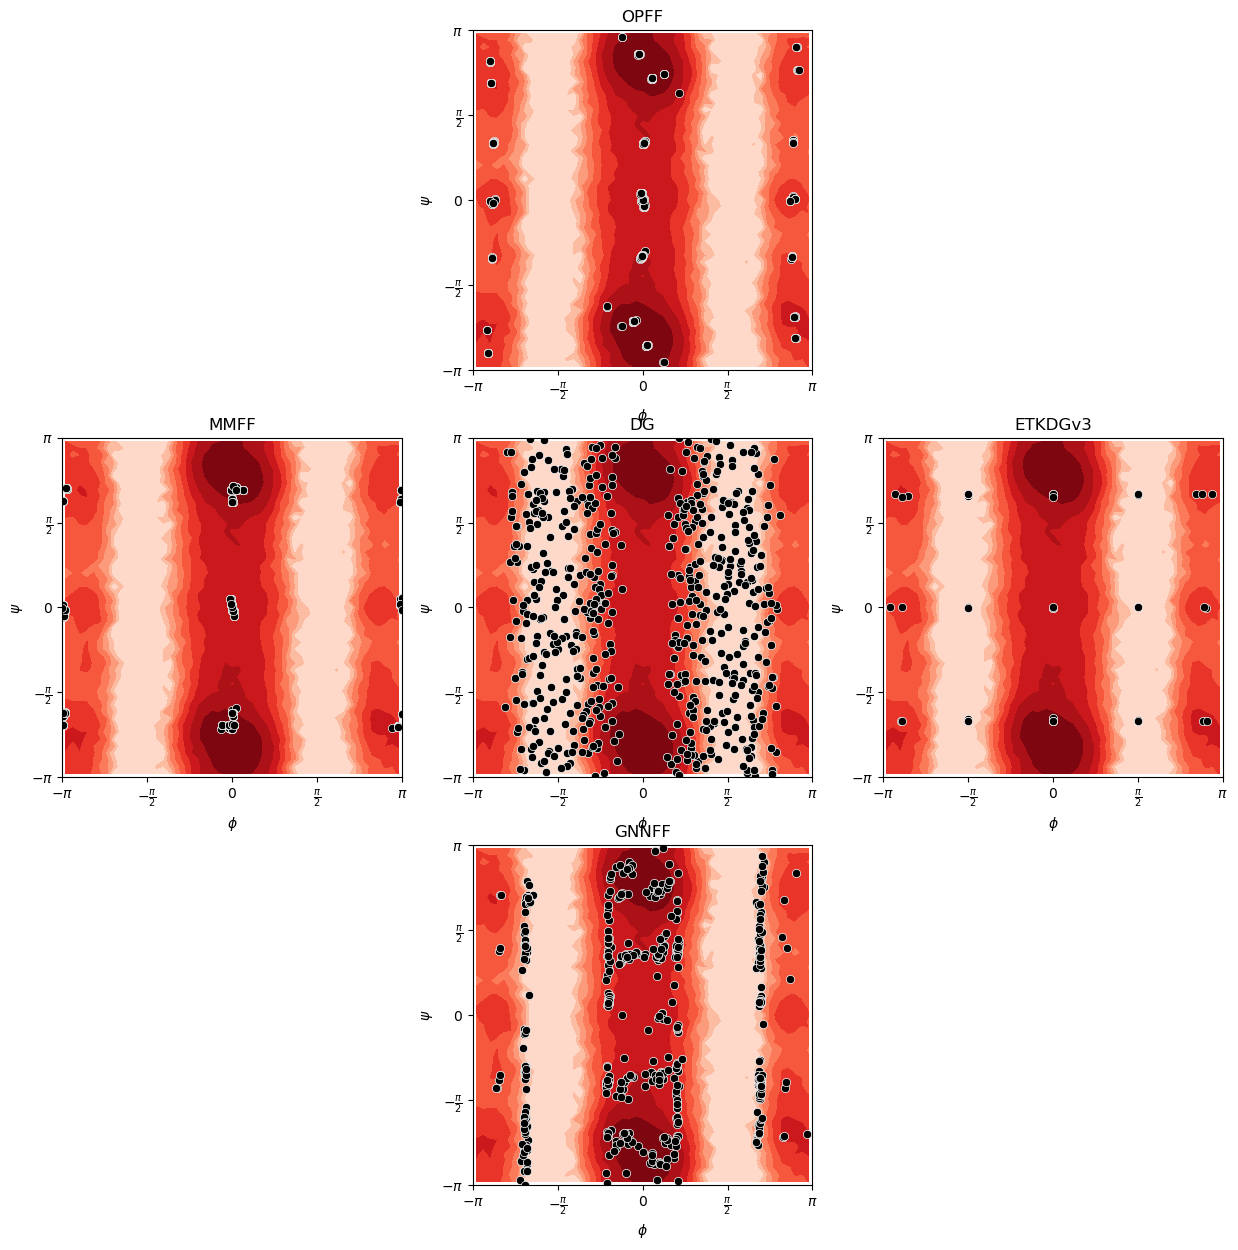

In [277]:
fig, axd = plt.subplot_mosaic([['EMPTY','opff','EMPTY'],['mmff','dg','etkdg'],['EMPTY','gnnff','EMPTY']],figsize=(15,15),empty_sentinel='EMPTY')
axd['dg'].set_title('DG')
axd['etkdg'].set_title('ETKDGv3')
axd['mmff'].set_title('MMFF')
axd['opff'].set_title('OPFF')
axd['gnnff'].set_title('GNNFF')

# plot_contour_f(axd,x,y,kjz,colors='Blues_r',vmax=20)
# plot_contour_f(axd,x_CHCl3,y_CHCl3,kjz_CHCl3,colors='Reds_r',vmax=20)
plot_contour_f(axd,x_DMSO,y_DMSO,kjz_DMSO,colors='Reds_r',vmax=20)

marker_style = dict(marker='o',edgecolor='white',lw=0.5)

axd['dg'].scatter(d1_dg,d2_dg,color='black',**marker_style)
axd['etkdg'].scatter(d1_etkdg,d2_etkdg,color='black',**marker_style)
axd['mmff'].scatter(d1_mmff,d2_mmff,color='black',**marker_style)
axd['opff'].scatter(d1_opff,d2_opff,color='black',**marker_style)
axd['gnnff'].scatter(d1_gnnff,d2_gnnff,color='black',**marker_style)

In [283]:
raw_gnnff_energies = deepcopy(gnnff_energies)
gnnff_energies -= np.min(gnnff_energies)

In [284]:
plot_dict = {'DMSO':(x_DMSO,y_DMSO,kjz_DMSO),
             'CO':(x_CO,y_CO,kjz_CO),
             'CHCl3':(x_CHCl3,y_CHCl3,kjz_CHCl3),
             'tip3p':(x,y,kjz)}

color_maps = {'DMSO':'Oranges_r',
                'CO':'Purples_r',
                'CHCl3':'Reds_r',
                'tip3p':'Blues_r'}

### Plain

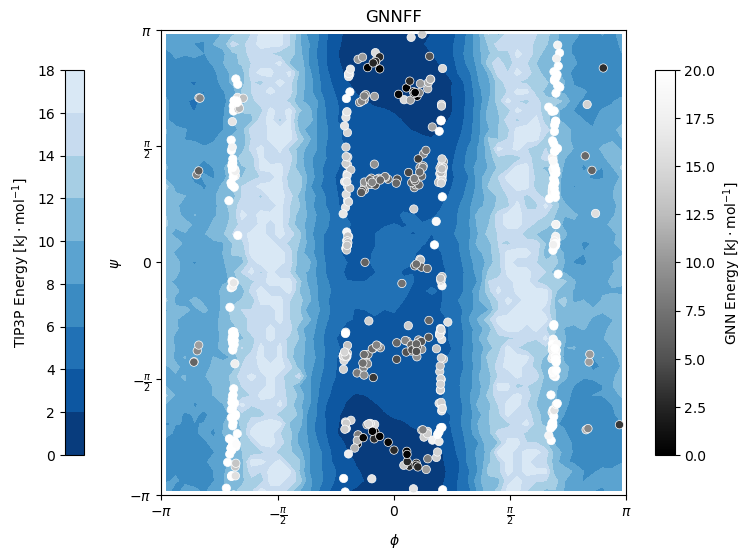

In [285]:
fig, axd = plt.subplot_mosaic([['gnnff']],figsize=(10,10),empty_sentinel='EMPTY')
axd['gnnff'].set_title('GNNFF')

contour = plot_contour_f(axd,*plot_dict[solventsmiles],colors=color_maps[solventsmiles],vmax=20)

marker_style = dict(marker='o',edgecolor='white',lw=0.5)
scatter = axd['gnnff'].scatter(d1_gnnff,d2_gnnff,c=gnnff_energies,cmap='Greys_r',**marker_style,vmax=20)
cbar = fig.colorbar(contour, ax=axd['gnnff'], shrink = 0.5,location='left', label='TIP3P Energy [$\mathrm{kJ \cdot mol^{-1}}$]')
cbar = fig.colorbar(scatter, ax=axd['gnnff'], shrink = 0.5,label='GNN Energy [$\mathrm{kJ \cdot mol^{-1}}$]',location='right')
fig.savefig('../Analysis/Plots/ID_%i_gnnff_unordered_s_%s.pdf' % (id,solventsmiles),bbox_inches='tight')

### Order

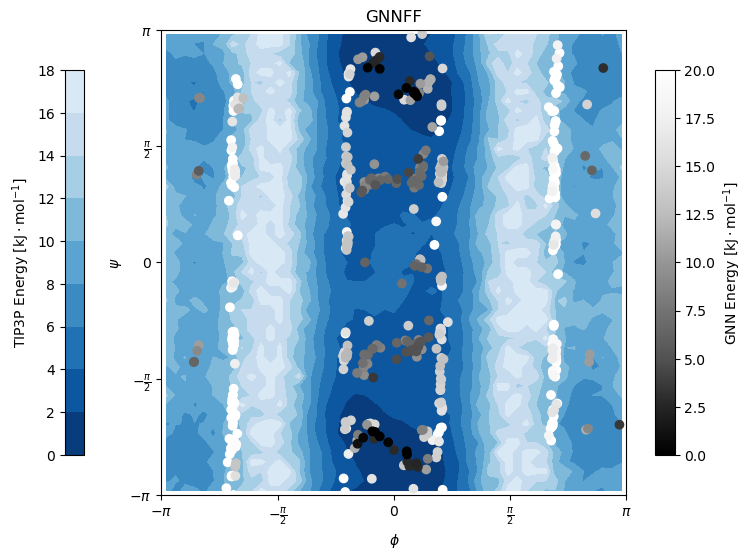

In [286]:
fig, axd = plt.subplot_mosaic([['gnnff']],figsize=(10,10),empty_sentinel='EMPTY')
axd['gnnff'].set_title('GNNFF')

contour = plot_contour_f(axd,*plot_dict[solventsmiles],colors=color_maps[solventsmiles],vmax=20)

marker_style = dict(marker='o')#,edgecolor='white',lw=0.5)
order = np.argsort(gnnff_energies)[::-1]
scatter = axd['gnnff'].scatter(d1_gnnff[order],d2_gnnff[order],c=gnnff_energies[order],cmap='Greys_r',**marker_style,vmax=20)
cbar = fig.colorbar(contour, ax=axd['gnnff'], shrink = 0.5,location='left', label='TIP3P Energy [$\mathrm{kJ \cdot mol^{-1}}$]')
cbar = fig.colorbar(scatter, ax=axd['gnnff'], shrink = 0.5,label='GNN Energy [$\mathrm{kJ \cdot mol^{-1}}$]',location='right')
fig.savefig('../Analysis/Plots/ID_%i_gnnff_order_s_%s.pdf' % (id,solventsmiles),bbox_inches='tight')

/tmp/ipykernel_992460/3585751291.py:6: UserWarning: No data for colormapping provided via 'c'. Parameters 'vmax' will be ignored
  scatter = axd['gnnff_noenergy'].scatter(d1_gnnff,d2_gnnff,c='grey',**marker_style,vmax=20)


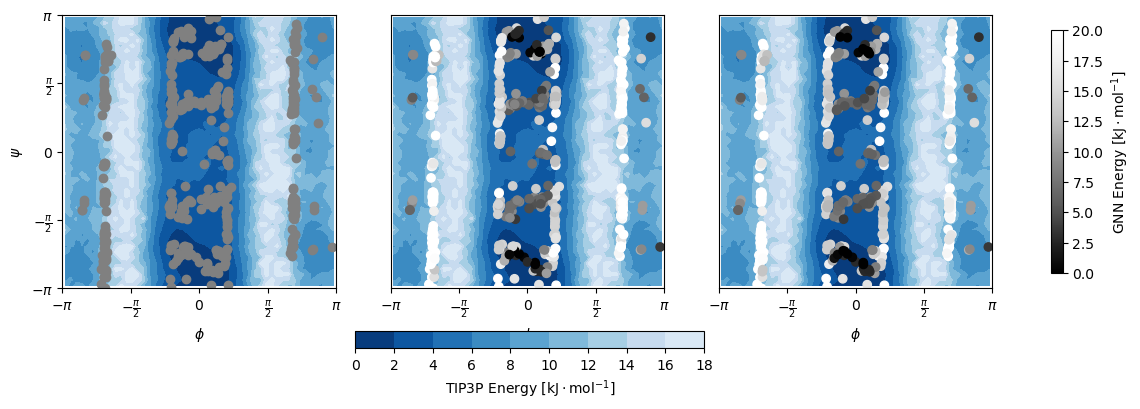

In [287]:
fig, axd = plt.subplot_mosaic([['gnnff_noenergy', 'gnnff_plain', 'gnnff_ordered']],figsize=(15,6),empty_sentinel='EMPTY')

contour = plot_contour_f(axd,*plot_dict[solventsmiles],colors=color_maps[solventsmiles],vmax=20)
marker_style = dict(marker='o')#,edgecolor='white',lw=0.5)
scatter = axd['gnnff_plain'].scatter(d1_gnnff,d2_gnnff,c=gnnff_energies,cmap='Greys_r',**marker_style,vmax=20)
scatter = axd['gnnff_noenergy'].scatter(d1_gnnff,d2_gnnff,c='grey',**marker_style,vmax=20)

order = np.argsort(gnnff_energies)[::-1]
scatter = axd['gnnff_ordered'].scatter(d1_gnnff[order],d2_gnnff[order],c=gnnff_energies[order],cmap='Greys_r',vmax=20)

axd['gnnff_plain'].get_yaxis().set_visible(False)
axd['gnnff_ordered'].get_yaxis().set_visible(False)

cbar = fig.colorbar(contour, ax=[axd['gnnff_ordered'],axd['gnnff_plain'],axd['gnnff_noenergy']], anchor=(0.36, 2), shrink = 0.3,location='bottom', label='TIP3P Energy [$\mathrm{kJ \cdot mol^{-1}}$]')
cbar = fig.colorbar(scatter, ax=[axd['gnnff_ordered'],axd['gnnff_plain'],axd['gnnff_noenergy']], shrink = 0.75,label='GNN Energy [$\mathrm{kJ \cdot mol^{-1}}$]',location='right')
fig.savefig('../Analysis/Plots/ID_%i_gnnff_min_comp_s_%s.pdf' % (id,solventsmiles),bbox_inches='tight')

In [288]:
def get_weighted_xyz(d1,d2,weights,num_bins=50):
    z, xedge, yedge = np.histogram2d(d1,d2,density=False,bins=np.linspace(-np.pi,np.pi,num=num_bins),weights=weights)
    x = 0.5 * (xedge[:-1] + xedge[1:])
    y = 0.5 * (yedge[:-1] + yedge[1:])
    z = z.T

    kjz = in_kjmol(z)

    return x,y,kjz

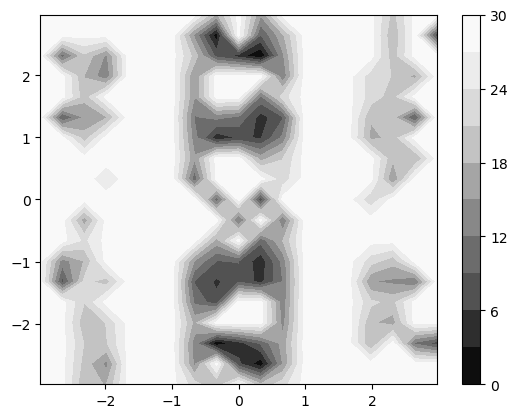

In [289]:
import matplotlib as mpl
# Put histogram on log scale
x_gnn, y_gnn, kjz_gnnff = get_weighted_xyz(d1_gnnff.flatten(),d2_gnnff.flatten(),np.exp(-(raw_gnnff_energies)/2.81),num_bins=20)
plt.contourf(x_gnn,y_gnn,kjz_gnnff,levels=10,cmap='Greys_r')
plt.colorbar()

### Only show smallest energies within gridpoint

In [290]:
d1_gnnff = d1_gnnff.flatten()
d2_gnnff = d2_gnnff.flatten()

In [291]:
def find_nearest(array, value):
    array = np.asarray(array)
    idx = ((array - value)**2).argmin()
    return idx

In [292]:
step =np.pi/2
rl = np.arange(-np.pi,np.pi+step,step)
points = []
for i in rl:
    for j in rl:
        truths = (d1_gnnff > i) & (d1_gnnff < i+step) & (d2_gnnff > j) & (d2_gnnff < j+step)
        if np.sum(truths):
            sd1 = d1_gnnff[truths]
            sd2 = d2_gnnff[truths]
            se = gnnff_energies[truths]
            min_e = np.argmin(se)
            points.append([sd1[min_e],sd2[min_e],se[min_e],plot_dict[solventsmiles][2][find_nearest(plot_dict[solventsmiles][1],sd2[min_e]),find_nearest(plot_dict[solventsmiles][0],sd1[min_e])]])
points = np.array(points)

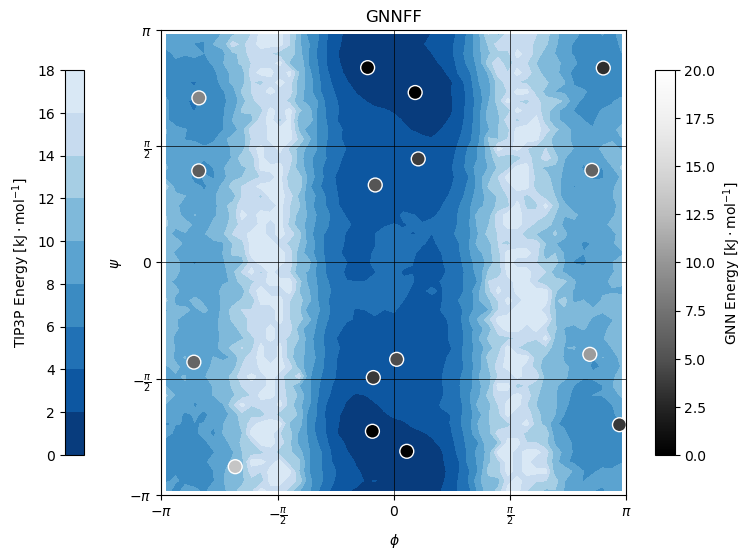

In [293]:
fig, axd = plt.subplot_mosaic([['gnnff']],figsize=(10,10),empty_sentinel='EMPTY')
axd['gnnff'].set_title('GNNFF')

contour = plot_contour_f(axd,*plot_dict[solventsmiles],colors=color_maps[solventsmiles],vmax=20)

marker_style = dict(marker='o',edgecolor='white',lw=1,s=100)
order = np.argsort(gnnff_energies)[::-1]
scatter = axd['gnnff'].scatter(points[:,0],points[:,1],c=points[:,2],cmap='Greys_r',**marker_style,vmax=20,zorder=2)
cbar = fig.colorbar(contour, ax=axd['gnnff'], shrink = 0.5,location='left', label='TIP3P Energy [$\mathrm{kJ \cdot mol^{-1}}$]')
cbar = fig.colorbar(scatter, ax=axd['gnnff'], shrink = 0.5,label='GNN Energy [$\mathrm{kJ \cdot mol^{-1}}$]',location='right')

# show grid
axd['gnnff'].hlines(rl,-np.pi,np.pi,color='black',linewidth=0.5,zorder=1)
axd['gnnff'].vlines(rl,-np.pi,np.pi,color='black',linewidth=0.5,zorder=1)
fig.savefig('../Analysis/Plots/ID_%i_gnnff_grid_s_%s.pdf' % (id,solventsmiles),bbox_inches='tight')

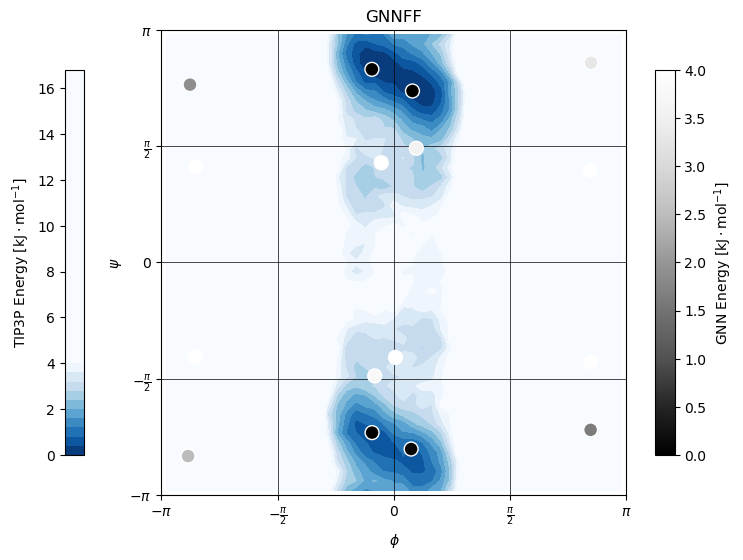

In [214]:
fig, axd = plt.subplot_mosaic([['gnnff']],figsize=(10,10),empty_sentinel='EMPTY')
axd['gnnff'].set_title('GNNFF')

contour = plot_contour_f(axd,*plot_dict[solventsmiles],colors=color_maps[solventsmiles],vmax=4,levels=50)

marker_style = dict(marker='o',edgecolor='white',lw=1,s=100)
order = np.argsort(gnnff_energies)[::-1]
scatter = axd['gnnff'].scatter(points[:,0],points[:,1],c=points[:,2],cmap='Greys_r',**marker_style,vmax=4,zorder=2)
cbar = fig.colorbar(contour, ax=axd['gnnff'], shrink = 0.5,location='left', label='TIP3P Energy [$\mathrm{kJ \cdot mol^{-1}}$]')
cbar = fig.colorbar(scatter, ax=axd['gnnff'], shrink = 0.5,label='GNN Energy [$\mathrm{kJ \cdot mol^{-1}}$]',location='right')

# show grid
axd['gnnff'].hlines(rl,-np.pi,np.pi,color='black',linewidth=0.5,zorder=1)
axd['gnnff'].vlines(rl,-np.pi,np.pi,color='black',linewidth=0.5,zorder=1)
fig.savefig('../Analysis/Plots/ID_%i_gnnff_grid_s_%s_zoom.pdf' % (id,solventsmiles),bbox_inches='tight')

### Get corresponging explicit energies

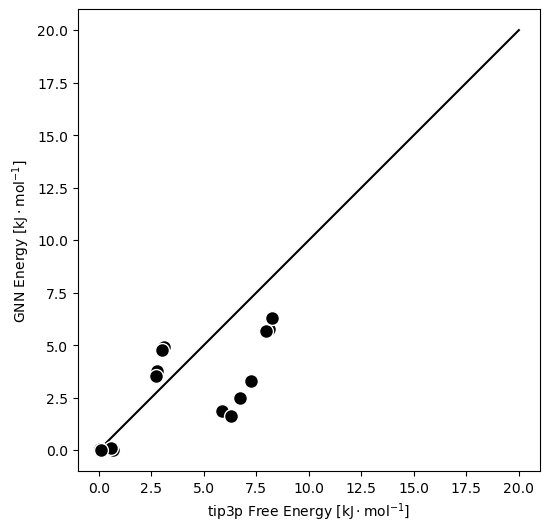

In [215]:
fig,axd = plt.subplot_mosaic([['comparison']],figsize=(6,6),empty_sentinel='EMPTY')
ax = axd['comparison']

tpoints = points[points[:,2] < 20]
tpoints = deepcopy(points)
tpoints[:,2][tpoints[:,2] > 20 ] = 20
ax.plot([0,20],[0,20],color='black',linestyle='solid')
# ax.plot([0,20],[4.18,24.18])

ax.scatter(tpoints[:,3],tpoints[:,2],**marker_style,zorder=10,color='black')
ax.set_aspect('equal')

ax.set_xlabel('%s Free Energy [$\mathrm{kJ \cdot mol^{-1}}$]' % solventsmiles)
ax.set_ylabel('GNN Energy [$\mathrm{kJ \cdot mol^{-1}}$]')
fig.savefig('../Analysis/Plots/ID_%i_gnnff_correlation_s_%s.pdf' % (id,solventsmiles),bbox_inches='tight')

## Try EBC again